In [2]:
import torch, numpy as np, matplotlib.pyplot as plt, torch.nn as nn, math, seaborn as sns, cvxpy as cp, scipy, copy

In [3]:
def mirror_descent_train(X_train, y_train, p, epsilon, model, potential_style, scale, lr, epoch, loss_ts, print_every, track_every=-1, init_param=None):
    
    loss_fn = nn.MSELoss()

    if track_every>0:
        model_track = []

    for ep in range(int(epoch)):
        loss = loss_fn(model(X_train), y_train)
        model.zero_grad()
        loss.backward()

        with torch.no_grad(): 
            for (idx, param) in enumerate(model.parameters()): 

                param_copy = torch.clone(param)           # copy current param
                grad_copy = torch.clone(param.grad)       # copy current gradient
                    
                if potential_style == 'scaled':    
                    hessian_phi = ( (p) * (p-1) * torch.abs( scale*(param_copy - init_param[idx]) )**(p-2) + 2 * epsilon ) / (epsilon+1)

                elif potential_style == 'original':    
                    hessian_phi = ( (p-1) * (p) * torch.abs(param_copy)**(p-2) + 2 * epsilon ) / (epsilon+1)

                hessian_phi_star = 1 / hessian_phi
                param.data = param_copy - lr * (hessian_phi_star * grad_copy)   # update

                if track_every>0 and ep % track_every == 0:   
                    model_temp = copy.deepcopy(model)
                    model_temp.eval()
                    model_track.append(model_temp)


        if print_every>0 and ep % print_every == 0: 
            print(f"{int(ep//print_every)}/{int(epoch//print_every)}"+f" loss:{loss.item()}")
        
        if loss.item() < loss_ts: 
            break
    
    if track_every<0:
        return model
    else:
        return model, model_track

In [4]:
class TwoLayer(nn.Module):
    
    def __init__(self, input_dim=1, num_neurons=100, activation='relu', inputbias_range=2):
        super(TwoLayer, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, num_neurons)
        self.output_layer = nn.Linear(num_neurons, 1)

        self.input_layer.weight.data = self.input_layer.weight.data.uniform_(-1, 1).sign()
        self.input_layer.bias.data.uniform_(-inputbias_range, inputbias_range)
        self.output_layer.weight.data.uniform_(0,0)
        self.output_layer.bias.data.uniform_(0,0)

        self.num_neurons = num_neurons
        self.activation = activation
        
    def forward(self, x):
        x = self.input_layer(x) 
        if self.activation == 'relu':
            x = torch.relu(x) 
        elif self.activation == 'abs':
            x = torch.nn.functional.leaky_relu(x, negative_slope=-1.)
        x = self.output_layer(x) 
        return x
    
    def init_param(self):
        output = []
        output.append(self.input_layer.weight.data.clone())
        output.append(self.input_layer.bias.data.clone())
        output.append(self.output_layer.weight.data.clone())
        output.append(self.output_layer.bias.data.clone())
        return output

In [6]:
def solution_1(X, y, xrange, num_grid): 
    xxx = np.linspace(-xrange, xrange, num_grid)
    delta_x = xxx[1]-xxx[0]
    idxlist = []
    for i in range(len(X)):
        idxlist.append(np.argmin( np.abs(xxx-X[i])))

    fx = cp.Variable(num_grid + 2) #fx[-2]: h'(-inf); fx[-1]: h'(inf)
    fp = (fx[1:-2] - fx[0:-3]) / delta_x  # len: num_grid - 1;    fp[0]: h'(xxx[0]) fp[-1]: h'(xxx[num_grid-2])
    lap = (fx[2:-2] - 2*fx[1:-3] + fx[0:-4]) / delta_x**2

    objective = -1 * (  2 * cp.sum(lap**2)*delta_x 
                        +  (fx[-1]+fx[-2])**2  
                        +  3 * (  (fx[-1]-fx[-2]) - (y[0]+y[-1]) )**2 )  
    
    constraints = []
    for i in range(len(X)):
        constraints.append(fx[idxlist[i]]==y[i])
    for i in range(idxlist[0]):
        constraints.append(fp[i]==fx[-2])
        constraints.append(fp[num_grid-i-2]==fx[-1])
    for i in range(idxlist[0]-1):
        constraints.append(lap[i]==0)
        constraints.append(lap[num_grid-i-3]==0)

    prob = cp.Problem(cp.Maximize(objective), constraints)
    prob.solve(verbose=False, solver=cp.SCS)
    #prob.solve(verbose=False, solver=cp.ECOS) 
    return fx.value[:-2]

In [7]:
def cubic_spline(X,y, xrange, num_grid): 

    xxx = np.linspace(-xrange, xrange, num_grid)
    delta_x = xxx[1]-xxx[0]
    idxlist = []
    for i in range(len(X)):
        idxlist.append(np.argmin( np.abs(xxx-X[i])))

    fx = cp.Variable(num_grid)
    lap = (fx[2:] - 2*fx[1:-1] + fx[0:-2]) / delta_x**2
    objective = -1 * cp.sum(lap**2)*delta_x   
    constraints = []
    for i in range(len(X)):
        constraints.append(fx[idxlist[i]]==y[i])

    prob = cp.Problem(cp.Maximize(objective), constraints)
    prob.solve(verbose=False, solver=cp.SCS)
    return fx.value


def eva(model, x):
    return model(torch.tensor(x, dtype=torch.float32).reshape(-1,1)).reshape(-1).detach().numpy()

In [8]:
X = np.array([-1., -0.2, 0., 0.2, 1.])
y = np.array([0., 0., 0.3, 0., 0.])
y -= .15

X_train = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [10]:
nlist = [20, 60, 180, 540, 1620, 4860]

model_list_4 = []
p = 4.
epsilon = 1. 
for j,n in enumerate(nlist):
    for seed in range(5):
        torch.manual_seed(seed)
        model = TwoLayer(input_dim = 1, num_neurons = n, activation='relu', inputbias_range=1.)
        model_trained = mirror_descent_train(X_train=X_train, y_train=y_train, p=p, epsilon=epsilon, model=model,
                                            potential_style='original', scale=-1, lr=n**-1, 
                                            epoch=1e7, loss_ts=1e-7, print_every=-1e3) 
        model_trained.eval()
        model_list_4.append(model_trained)
    print('finished n=', n, 'p=',p)

model_list_3 = []
p = 3.
epsilon = 1.
for j,n in enumerate(nlist):
    for seed in range(5):
        torch.manual_seed(seed)
        model = TwoLayer(input_dim = 1, num_neurons = n, activation='relu', inputbias_range=1.)
        model_trained  = mirror_descent_train(X_train=X_train, y_train=y_train, p=p, epsilon=epsilon, model=model,
                                            potential_style='original', scale=-1, lr=n**-1, 
                                            epoch=1e7, loss_ts=1e-7, print_every=-1e3) 
        model_trained.eval()
        model_list_3.append(model_trained)
    print('finished n=', n, 'p=',p)

model_list_2 = []
p = 2.
epsilon = 1.
for j,n in enumerate(nlist):
    for seed in range(5):
        torch.manual_seed(seed)
        model = TwoLayer(input_dim = 1, num_neurons = n, activation='relu', inputbias_range=1.)
        model_trained = mirror_descent_train(X_train=X_train, y_train=y_train, p=p, epsilon=epsilon, model=model,
                                            potential_style='original', scale=-1, lr=n**-1, 
                                            epoch=1e7, loss_ts=1e-7, print_every=-1e3) 
        model_trained.eval()
        model_list_2.append(model_trained)
    print('finished n=', n, 'p=',p)

finished n= 20 p= 4.0
finished n= 60 p= 4.0
finished n= 180 p= 4.0
finished n= 540 p= 4.0
finished n= 1620 p= 4.0
finished n= 4860 p= 4.0
finished n= 20 p= 3.0
finished n= 60 p= 3.0
finished n= 180 p= 3.0
finished n= 540 p= 3.0
finished n= 1620 p= 3.0
finished n= 4860 p= 3.0
finished n= 20 p= 2.0
finished n= 60 p= 2.0
finished n= 180 p= 2.0
finished n= 540 p= 2.0
finished n= 1620 p= 2.0
finished n= 4860 p= 2.0


In [15]:
xrange = 1.5
num_grid = 501
xxx = np.linspace(-xrange, xrange, num_grid)
var_solution = solution_1(X, y, xrange, num_grid)
error_type = np.inf

errorlist_2,varlist_2 = [],[]
for i,model in enumerate(model_list_2): 
    if i % 5 == 0:
        temp_list = []
    model_output = eva(model_list_2[i], xxx) 
    temp_list.append( np.linalg.norm(model_output - var_solution, ord=error_type)) 

    if i % 5 == 4:
        errorlist_2.append( np.mean(np.array(temp_list)) )
        varlist_2.append( np.std(np.array(temp_list)) )

errorlist_3,varlist_3 = [],[]
for i,model in enumerate(model_list_3): 
    if i % 5 == 0:
        temp_list = []
    model_output = eva(model_list_3[i], xxx) 
    temp_list.append( np.linalg.norm(model_output - var_solution, ord=error_type)) 

    if i % 5 == 4:
        errorlist_3.append( np.mean(np.array(temp_list)) )
        varlist_3.append( np.std(np.array(temp_list)) )

errorlist_4,varlist_4 = [],[]
for i,model in enumerate(model_list_4): 
    if i % 5 == 0:
        temp_list = []
    model_output = eva(model_list_4[i], xxx) 
    temp_list.append( np.linalg.norm(model_output - var_solution, ord=error_type)) 

    if i % 5 == 4:
        errorlist_4.append( np.mean(np.array(temp_list)) )
        varlist_4.append( np.std(np.array(temp_list)) )


In [12]:
model_list_yshift = []
yshift_list = [2.5, 1., -.5, -2., -3.5]
p, epsilon = 2.,1. 
for yshift in yshift_list:
    torch.manual_seed(0)
    num_neurons = 4860
    model = TwoLayer(input_dim = 1, num_neurons = num_neurons, activation='relu', inputbias_range=1.)
    model_trained = mirror_descent_train(X_train=X_train, y_train=y_train+yshift, p=p, epsilon=epsilon, model=model,
                                            potential_style='original', scale=-1, lr=n**-1, 
                                            epoch=1e7, loss_ts=1e-7, print_every=-1e3) 
    model_trained.eval()
    model_list_yshift.append(model_trained)

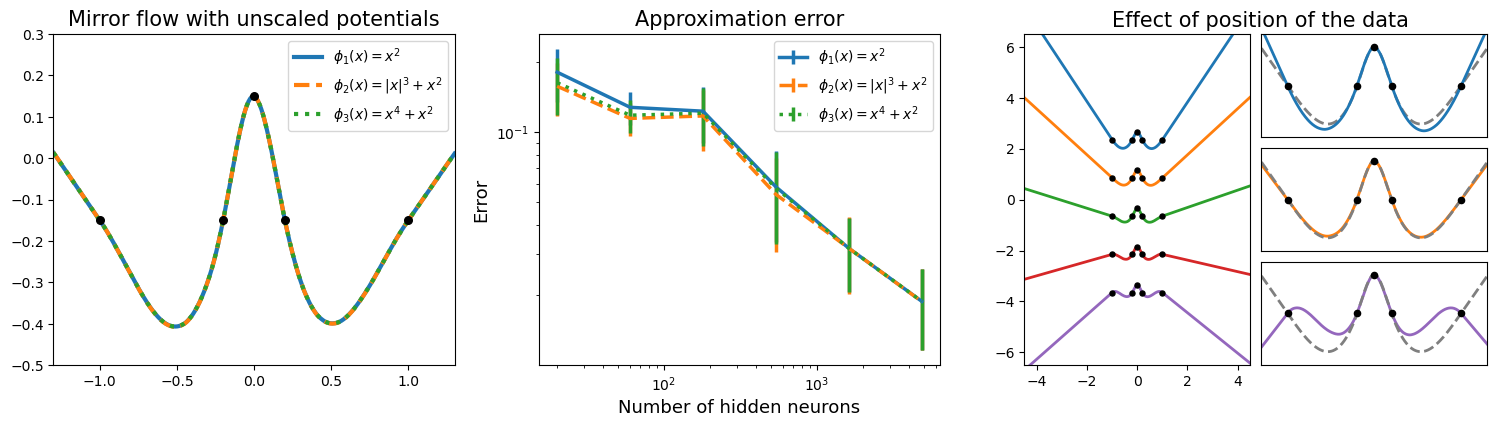

In [17]:
import matplotlib.gridspec as gridspec
                                            
fig = plt.figure(figsize=(18.5,4.3))

outer = gridspec.GridSpec(1, 3, width_ratios=[1.3, 1.3, 1.5], wspace=.2)

ax0 = plt.subplot(outer[0])
ax1 = plt.subplot(outer[1])
mid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[2], wspace=0.05)
ax2 = plt.subplot(mid[0])
inner = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=mid[1], hspace=0.1)
ax3 = plt.subplot(inner[0])
ax4 = plt.subplot(inner[1])
ax5 = plt.subplot(inner[2])


FS = 13 #15
labellist= [f'$\phi_1(x)=x^2$',f'$\phi_2(x)= |x|^3+x^2$',f'$\phi_3(x)= x^4 + x^2$']

### left panel
ax = ax0
fig_xrange = 1.3
fig_x = np.linspace(-fig_xrange,fig_xrange,num_grid)
output_list = []
output_list.append(eva(model_list_2[-3], fig_x))
output_list.append(eva(model_list_3[-3], fig_x))
output_list.append(eva(model_list_4[-3], fig_x))
ax.scatter(X_train, y_train, s=30, c='black',zorder=2)
for i, output in enumerate(output_list):
    ax.plot(fig_x, output, label=labellist[i], linestyle=['-', 'dashed', 'dotted'][i], linewidth=3, zorder=1)
ax.legend(fontsize=FS-3, loc='upper right')
ax.set_title("Mirror flow with unscaled potentials", fontsize=FS+2)
ax.set_xlim(-1.3 , 1.3)
ax.set_ylim(-.5, .3)

### mid panel
ax = ax1
ax.errorbar(nlist, errorlist_2, yerr=varlist_2, label=labellist[0], ls='-', lw=2.5)#, marker='o',markersize=5)
ax.errorbar(nlist, errorlist_3, yerr=varlist_3, label=labellist[1], ls='dashed', lw=2.5)#, marker='o')
ax.errorbar(nlist, errorlist_4, yerr=varlist_4, label=labellist[2], ls='dotted', lw=2.5)#, marker='o')
ax.legend(fontsize=FS-3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(r"Approximation error", fontsize=FS+2)
ax.set_ylabel('Error', fontsize=FS)
ax.set_xlabel('Number of hidden neurons', fontsize=FS)



### right panel
fig_xx = np.linspace(-10,10,num_grid)
for i, model in enumerate(model_list_yshift): 
    ax2.plot(fig_xx, eva(model, fig_xx), zorder=0, linewidth=2)
    ax2.scatter(X_train, y_train + yshift_list[i], s=13, c='black', zorder=1)
ax2.set_xlim(-4.5,4.5) #5
ax2.set_ylim(-6.5,6.5) #6.5
ax2.text(-1, 6.78, "Effect of position of the data", fontsize=FS+2)

cubic_y = cubic_spline(X, y, fig_xrange, num_grid)

ax3.scatter(X_train, y_train + yshift_list[0], s=20, c='black', zorder=3)
ax3.plot(fig_x, cubic_y + yshift_list[0], label='Cubic spline', color='tab:gray',linewidth=2,linestyle='--', zorder=0)
ax3.plot(fig_x, eva(model_list_yshift[0], fig_x), color='tab:blue',linewidth=2, zorder=0)
ax3.set_xlim(-1.3,1.3)
ax3.set_ylim(1.95, 2.75)
ax3.set_yticks([])
ax3.set_xticks([])
#ax3.legend(fontsize=FS-3, loc='upper right')

ax4.scatter(X_train, y_train + yshift_list[1], s=20, c='black', zorder=3)
ax4.plot(fig_x, cubic_y + yshift_list[1],  label='Cubic spline', color='tab:gray',linewidth=2,linestyle='--', zorder=2)
ax4.plot(fig_x, eva(model_list_yshift[1], fig_x),  color='tab:orange',linewidth=2, zorder=0)
ax4.set_xlim(-1.3,1.3)
ax4.set_ylim(1.95-1.5, 2.75-1.5)
ax4.set_yticks([])
ax4.set_xticks([])
#ax4.legend(fontsize=FS-3, loc='upper right')

ax5.scatter(X_train, y_train + yshift_list[-1], s=20, c='black', zorder=3)
ax5.plot(fig_x, cubic_y + yshift_list[-1],  label='Cubic spline', color='tab:gray',linewidth=2, linestyle='--', zorder=2)
ax5.plot(fig_x, eva(model_list_yshift[-1], fig_x),  color='tab:purple',linewidth=2, zorder=0)
ax5.set_xlim(-1.3,1.3)
ax5.set_ylim(1.95-1.5*4, 2.75-1.5*4)
ax5.set_yticks([])
ax5.set_xticks([])
#ax5.legend(fontsize=FS-4, loc='upper right')

plt.savefig('output/Thm1-final.png', dpi=300, bbox_inches='tight')